In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process


In [5]:
claims_path = "C:/Users/archa/Desktop/Databricks/Data/raw/NTA_MTC_Claims_Synthetic_Data.xlsx"
df = pd.read_excel(claims_path, sheet_name=0, engine="openpyxl")

df.head()

,CLAIM NUMBER,POLICY,RISK STATE,DATE OF LOSS,NOTICE DATE,AMOUNT,DATE,COMPANY,TYPE,COVERAGE,ACCIDENT STATE,ACCIDENT COMMENTS
0,CLM10001,UKQ55567963,TX,2020-01-17,2020-01-21,25000,2020-01-22,WORLD SPECIALTY INSURANCE CO,START-LOSS-RSV,551-INDIA MARINE - PRIMARY/REEFER,WY,IV SLID ON ICE INTO A TRAILER
1,CLM10001,UKQ55567963,TX,2020-01-17,2020-01-21,5000,2020-01-29,WORLD SPECIALTY INSURANCE CO,START-LOSS-RSV,553-INDIA MARINE - DEBRIS REMOVAL,WY,IV SLID ON ICE INTO A TRAILER
2,CLM10001,UKQ55567963,TX,2020-01-17,2020-01-21,5000,2020-02-19,WORLD SPECIALTY INSURANCE CO,INDEMNITY-PAID,553-INDIA MARINE - DEBRIS REMOVAL,WY,IV SLID ON ICE INTO A TRAILER
3,CLM10001,UKQ55567963,TX,2020-01-17,2020-01-21,-18525,2020-02-20,WORLD SPECIALTY INSURANCE CO,RSV-LOSS-CHG,551-INDIA MARINE - PRIMARY/REEFER,WY,IV SLID ON ICE INTO A TRAILER
4,CLM10001,UKQ55567963,TX,2020-01-17,2020-01-21,6475,2020-02-20,WORLD SPECIALTY INSURANCE CO,INDEMNITY-PAID,551-INDIA MARINE - PRIMARY/REEFER,WY,IV SLID ON ICE INTO A TRAILER


In [ ]:
# Step 1: Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.upper()

# Step 2: Convert dates to datetime
date_columns = ['DATE_OF_LOSS', 'NOTICE_DATE', 'DATE']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Step 3: Convert amount to numeric
df['AMOUNT'] = pd.to_numeric(df['AMOUNT'], errors='coerce')

# Step 4: Drop rows with missing essential data
df_clean = df.dropna(subset=['CLAIM_NUMBER', 'AMOUNT', 'DATE'])

# Create MONTH_YEAR from DATE column 
df_clean['MONTH_YEAR'] = df_clean['DATE'].dt.to_period('M')
df_clean['MONTH_YEAR'] = df_clean['MONTH_YEAR'].dt.to_timestamp()



C:\Users\archa\AppData\Local\Temp\ipykernel_22808\3071987944.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['MONTH_YEAR'] = df_clean['DATE'].dt.to_period('M')
C:\Users\archa\AppData\Local\Temp\ipykernel_22808\3071987944.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['MONTH_YEAR'] = df_clean['MONTH_YEAR'].dt.to_timestamp()


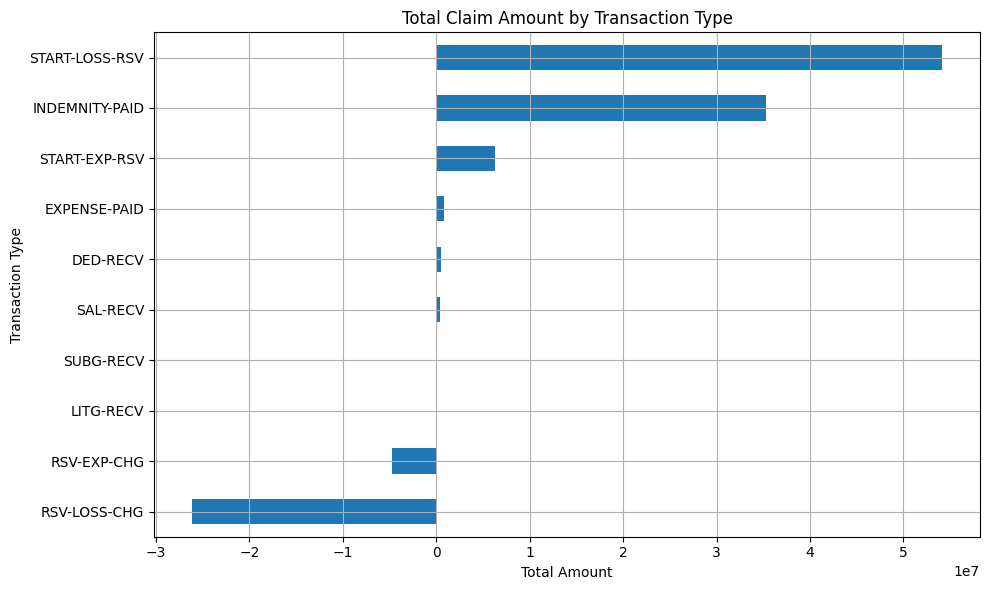

In [24]:
# 5.1 Total claim amount per TYPE
type_amount = df_clean.groupby('TYPE')['AMOUNT'].sum().sort_values()
plt.figure(figsize=(10,6))
type_amount.plot(kind='barh')
plt.title('Total Claim Amount by Transaction Type')
plt.xlabel('Total Amount')
plt.ylabel('Transaction Type')
plt.grid(True)
plt.tight_layout()
plt.show()

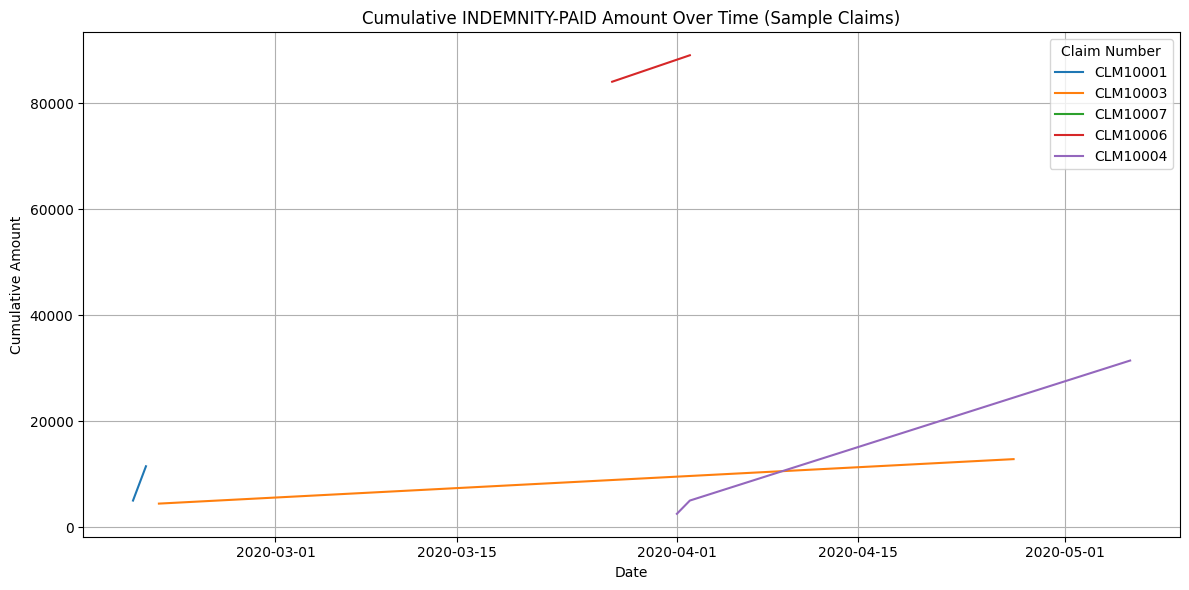

In [25]:
# 5.2 Cumulative paid amount per CLAIM_NUMBER over time
claim_time = df_clean[df_clean['TYPE'] == 'INDEMNITY-PAID']
claim_time = claim_time.sort_values(by='DATE')
claim_time['CUMSUM'] = claim_time.groupby('CLAIM_NUMBER')['AMOUNT'].cumsum()

# Plot a few sample claims
sample_claims = claim_time['CLAIM_NUMBER'].unique()[:5]
plt.figure(figsize=(12, 6))
for claim in sample_claims:
    subset = claim_time[claim_time['CLAIM_NUMBER'] == claim]
    plt.plot(subset['DATE'], subset['CUMSUM'], label=claim)
plt.title('Cumulative INDEMNITY-PAID Amount Over Time (Sample Claims)')
plt.xlabel('Date')
plt.ylabel('Cumulative Amount')
plt.legend(title='Claim Number')
plt.grid(True)
plt.tight_layout()
plt.show()

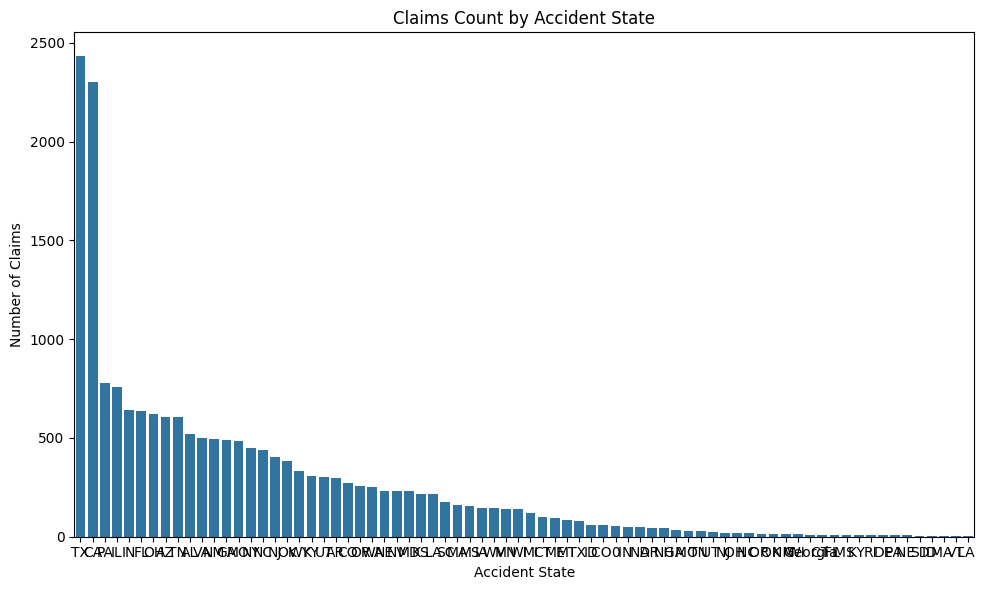

In [26]:
# 5.3 Distribution by ACCIDENT_STATE
accident_state = df_clean['ACCIDENT_STATE'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=accident_state.index, y=accident_state.values)
plt.title('Claims Count by Accident State')
plt.xlabel('Accident State')
plt.ylabel('Number of Claims')
plt.tight_layout()
plt.show()


C:\Users\archa\AppData\Local\Temp\ipykernel_22808\4031164503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['MONTH_YEAR'] = df_clean['DATE'].dt.to_period('M')


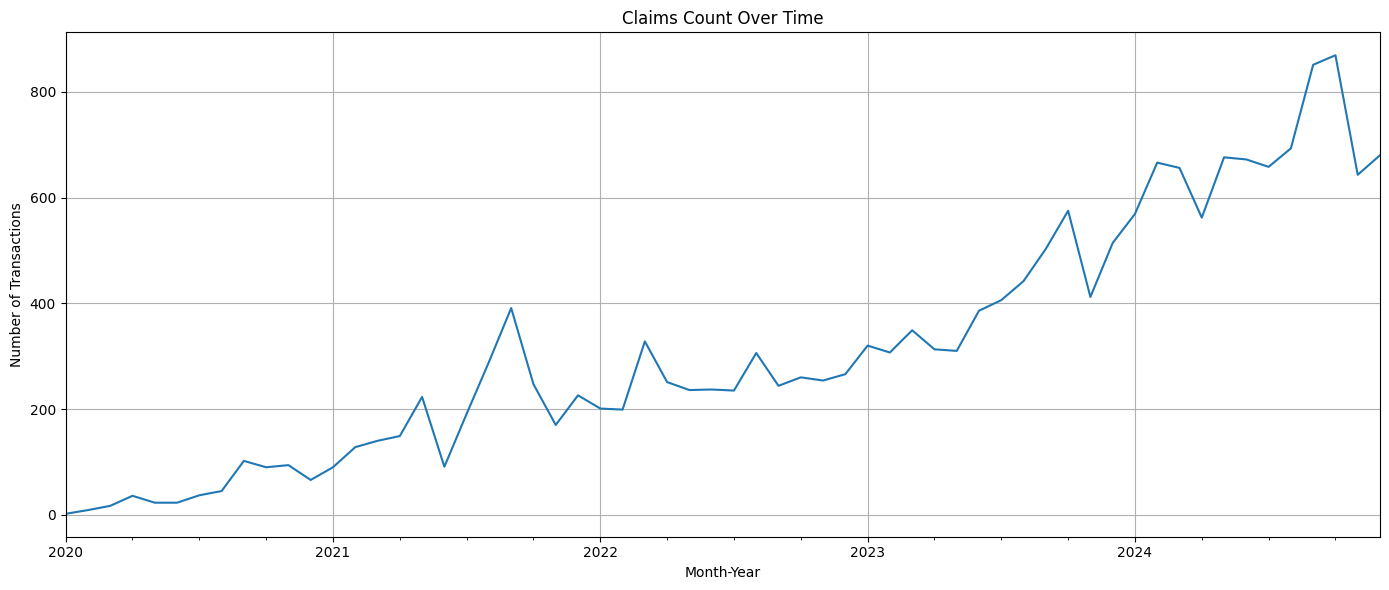

In [27]:
# 5.4 Claims count by month/year
df_clean['MONTH_YEAR'] = df_clean['DATE'].dt.to_period('M')
monthly_claims = df_clean.groupby('MONTH_YEAR').size()

plt.figure(figsize=(14,6))
monthly_claims.plot()
plt.title('Claims Count Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# Calculate the time delta between DATE_OF_LOSS and NOTICE_DATE
df_clean['DAYS_TO_NOTICE'] = (df_clean['NOTICE_DATE'] - df_clean['DATE_OF_LOSS']).dt.days

# Average days to notice per claim type
avg_days_notice_by_type = df_clean.groupby('TYPE')['DAYS_TO_NOTICE'].mean().sort_values()

# Pivot table: Claim count and total amount by TYPE and ACCIDENT_STATE
pivot_table = pd.pivot_table(
    df_clean,
    values='AMOUNT',
    index='TYPE',
    columns='ACCIDENT_STATE',
    aggfunc=['count', 'sum'],
    fill_value=0
)
print("\nAverage Days Between Loss and Notice (by Claim Type):")
print(avg_days_notice_by_type.reset_index())

print("\nClaims Pivot Table by Type and State:")
print(pivot_table)


Average Days Between Loss and Notice (by Claim Type):
             TYPE  DAYS_TO_NOTICE
0       SUBG-RECV        3.333333
1        SAL-RECV        6.265306
2  INDEMNITY-PAID       15.324312
3        DED-RECV       19.992126
4       LITG-RECV       27.000000
5    EXPENSE-PAID       27.805596
6    RSV-LOSS-CHG       31.499453
7  START-LOSS-RSV       37.182449
8     RSV-EXP-CHG       48.795221
9   START-EXP-RSV       52.785347

Claims Pivot Table by Type and State:
               count                                         ...        sum  \
ACCIDENT_STATE     0   AL  AR AR    AZ   CA  CO CO   CT CT   ...        TX    
TYPE                                                         ...              
DED-RECV           0   19  10   1   26   68  17   2   3   1  ...    2000.00   
EXPENSE-PAID       0   22  12   4   22   68   7  13   5   1  ...    6827.94   
INDEMNITY-PAID     1   70  42  18   79  184  34   5  11   1  ...  117405.70   
LITG-RECV          0    0   0   0    2    0   0   0   0   

C:\Users\archa\AppData\Local\Temp\ipykernel_22808\2479841082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['DAYS_TO_NOTICE'] = (df_clean['NOTICE_DATE'] - df_clean['DATE_OF_LOSS']).dt.days


<Figure size 1400x600 with 0 Axes>

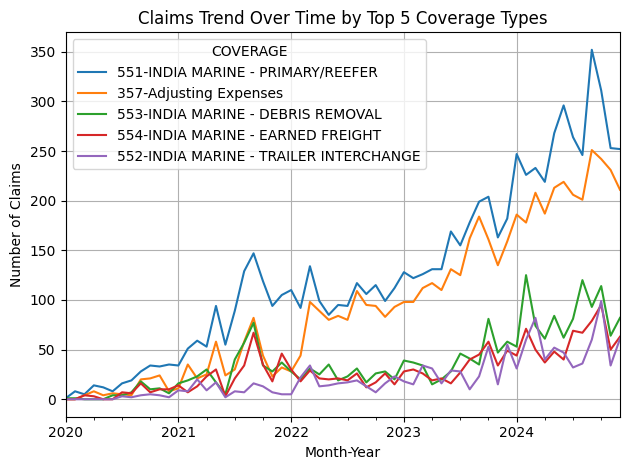

In [29]:
# Group by Month-Year and Coverage
coverage_trend = df_clean.groupby([df_clean['DATE'].dt.to_period('M'), 'COVERAGE']).size().unstack(fill_value=0)

# Group by Month-Year and Company
company_trend = df_clean.groupby([df_clean['DATE'].dt.to_period('M'), 'COMPANY']).size().unstack(fill_value=0)

# Limit to top 5 most frequent COVERAGE and COMPANY for clean visualization
top_coverages = df_clean['COVERAGE'].value_counts().nlargest(5).index
top_companies = df_clean['COMPANY'].value_counts().nlargest(5).index

# Filter trends for top 5
coverage_trend_top5 = coverage_trend[top_coverages]
company_trend_top5 = company_trend[top_companies]

# Plot coverage trend
plt.figure(figsize=(14, 6))
coverage_trend_top5.plot()
plt.title('Claims Trend Over Time by Top 5 Coverage Types')
plt.xlabel('Month-Year')
plt.ylabel('Number of Claims')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

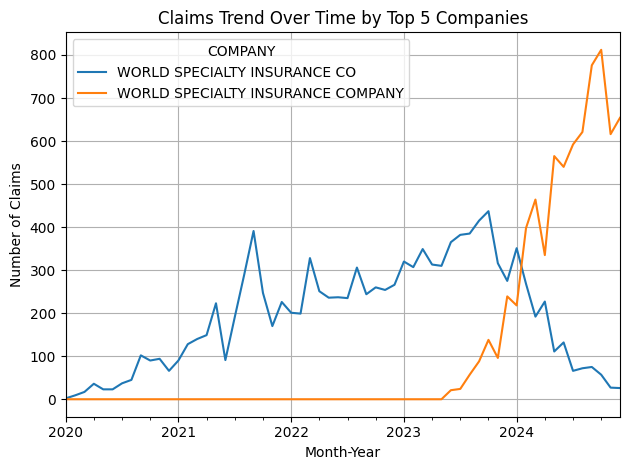

In [30]:
# Plot company trend
plt.figure(figsize=(14, 6))
company_trend_top5.plot()
plt.title('Claims Trend Over Time by Top 5 Companies')
plt.xlabel('Month-Year')
plt.ylabel('Number of Claims')
plt.grid(True)
plt.tight_layout()
plt.show()

Correlate these trends with AMOUNT or TYPE

<Figure size 1400x600 with 0 Axes>

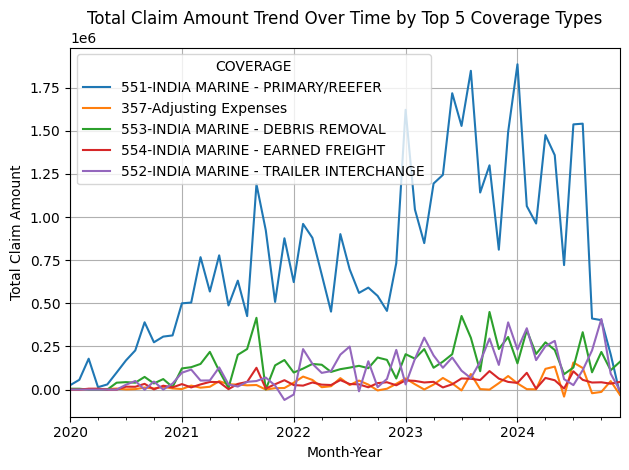

In [31]:
# Aggregate total claim amount by month and coverage
coverage_amount_trend = df_clean.groupby([df_clean['DATE'].dt.to_period('M'), 'COVERAGE'])['AMOUNT'].sum().unstack(fill_value=0)

# Aggregate total claim amount by month and company
company_amount_trend = df_clean.groupby([df_clean['DATE'].dt.to_period('M'), 'COMPANY'])['AMOUNT'].sum().unstack(fill_value=0)

# Limit to top 5 coverages and companies again
coverage_amount_top5 = coverage_amount_trend[top_coverages]
company_amount_top5 = company_amount_trend[top_companies]

# Plot claim amount trend by coverage
plt.figure(figsize=(14, 6))
coverage_amount_top5.plot()
plt.title('Total Claim Amount Trend Over Time by Top 5 Coverage Types')
plt.xlabel('Month-Year')
plt.ylabel('Total Claim Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

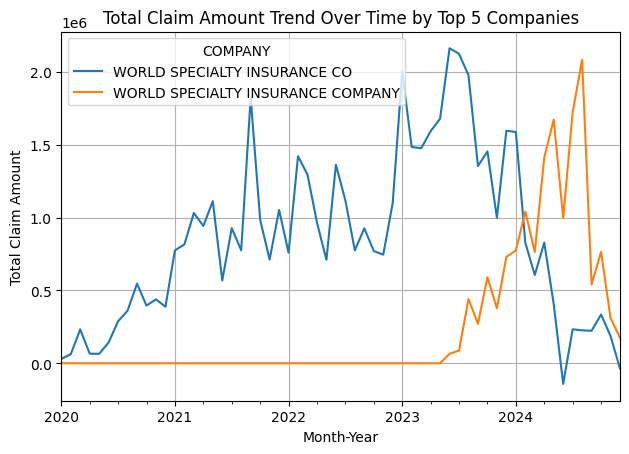

,TYPE,count,sum,mean,std
0,START-LOSS-RSV,4467,54173640.28,12127.521889,6137.497595
1,INDEMNITY-PAID,2217,35268794.66,15908.342201,25441.568157
2,START-EXP-RSV,2525,6331029.05,2507.338238,1211.340794
3,EXPENSE-PAID,679,824006.44,1213.558822,2540.061800
4,DED-RECV,762,466000.00,611.548556,2827.966765
5,SAL-RECV,49,370939.49,7570.193673,18958.444944
6,SUBG-RECV,27,26862.64,994.912593,20791.402455
7,LITG-RECV,2,0.00,0.000000,14142.135624
8,RSV-EXP-CHG,2720,-4773761.30,-1755.059301,2189.548539
9,RSV-LOSS-CHG,5480,-26176017.25,-4776.645484,21735.744124


In [32]:
# Plot claim amount trend by company
plt.figure(figsize=(14, 6))
company_amount_top5.plot()
plt.title('Total Claim Amount Trend Over Time by Top 5 Companies')
plt.xlabel('Month-Year')
plt.ylabel('Total Claim Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation matrix: Type vs. Amount
type_amount = df_clean.groupby(['TYPE'])['AMOUNT'].agg(['count', 'sum', 'mean', 'std']).sort_values(by='sum', ascending=False)

# Display result
import pandas as pd
type_amount.reset_index(inplace=True)
type_amount

C:\Users\archa\AppData\Local\Temp\ipykernel_22808\380006830.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['COMPANY_NORMALIZED'] = df_clean['COMPANY'].map(normalized_map)
15:00:37 - cmdstanpy - INFO - Chain [1] start processing
15:00:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\archa\Desktop\Databricks\Claims_env\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


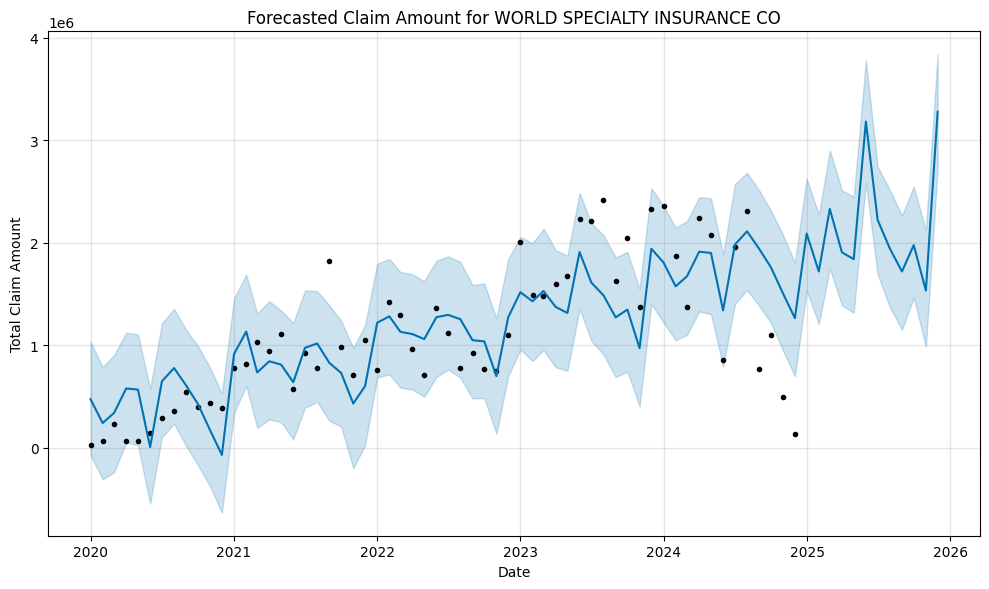

In [33]:
# Step 1: Normalize company names (fix applied)
unique_companies = df_clean['COMPANY'].dropna().unique()
normalized_map = {}
standardized_names = []

for company in unique_companies:
    if not standardized_names:
        normalized_map[company] = company
        standardized_names.append(company)
    else:
        match, score = process.extractOne(company, standardized_names, scorer=fuzz.token_sort_ratio)
        if score > 90:
            normalized_map[company] = match
        else:
            normalized_map[company] = company
            standardized_names.append(company)

df_clean['COMPANY_NORMALIZED'] = df_clean['COMPANY'].map(normalized_map)

# Step 2: Forecast using Prophet for top company
top_company = df_clean['COMPANY_NORMALIZED'].value_counts().idxmax()

forecast_df = (
    df_clean[df_clean['COMPANY_NORMALIZED'] == top_company]
    .groupby(df_clean['DATE'].dt.to_period('M'))['AMOUNT']
    .sum()
    .reset_index()
)

forecast_df['DATE'] = forecast_df['DATE'].astype(str)
forecast_df.columns = ['ds', 'y']

# Train Prophet
from prophet import Prophet
model = Prophet()
model.fit(forecast_df)

# Predict next 12 months
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title(f'Forecasted Claim Amount for {top_company}')
plt.xlabel('Date')
plt.ylabel('Total Claim Amount')
plt.tight_layout()
plt.show()


In [35]:
# Optional: inspect problematic dtypes
print(df_clean.dtypes)

CLAIM_NUMBER                  object
POLICY                        object
RISK_STATE                    object
DATE_OF_LOSS          datetime64[ns]
NOTICE_DATE           datetime64[ns]
AMOUNT                       float64
DATE                  datetime64[ns]
COMPANY                       object
TYPE                          object
COVERAGE                      object
ACCIDENT_STATE                object
ACCIDENT_COMMENTS             object
MONTH_YEAR                 period[M]
DAYS_TO_NOTICE                 int64
COMPANY_NORMALIZED            object
dtype: object


In [38]:
# Recreate MONTH_YEAR if missing or wrong type
if 'MONTH_YEAR' not in df_clean.columns or str(df_clean['MONTH_YEAR'].dtype).startswith('period'):
    df_clean['MONTH_YEAR'] = df_clean['DATE'].dt.to_period('M')
    df_clean['MONTH_YEAR'] = df_clean['MONTH_YEAR'].dt.to_timestamp()


C:\Users\archa\AppData\Local\Temp\ipykernel_22808\2108784156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['MONTH_YEAR'] = df_clean['DATE'].dt.to_period('M')
C:\Users\archa\AppData\Local\Temp\ipykernel_22808\2108784156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['MONTH_YEAR'] = df_clean['MONTH_YEAR'].dt.to_timestamp()


In [39]:
print(df_clean.dtypes)


CLAIM_NUMBER                  object
POLICY                        object
RISK_STATE                    object
DATE_OF_LOSS          datetime64[ns]
NOTICE_DATE           datetime64[ns]
AMOUNT                       float64
DATE                  datetime64[ns]
COMPANY                       object
TYPE                          object
COVERAGE                      object
ACCIDENT_STATE                object
ACCIDENT_COMMENTS             object
MONTH_YEAR            datetime64[ns]
DAYS_TO_NOTICE                 int64
COMPANY_NORMALIZED            object
dtype: object


In [40]:
output_path = "C:/Users/archa/Desktop/Databricks/Data/processed"

df_clean.to_parquet(f"{output_path}/claims_cleaned.parquet", index=False, engine='fastparquet')
df_clean.to_csv(f"{output_path}/claims_cleaned.csv", index=False)

print("🎉 File successfully saved to processed folder.")


🎉 File successfully saved to processed folder.
